## Equity in Responsiveness: Analysis of Service Delays by Neighborhood

Are some neighborhoods systematically slower to receive service, even after accounting for service type?
We isolate government responsiveness by computing the delay relative to expected resolution time for each service type.


# Equity Analysis

Here we will see whether 311 requests are equitably solved.


In [1]:
!pip install -r ../requirements.txt --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind, spearmanr
import geopandas as gpd
import os

import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings

from matplotlib.patches import Patch

warnings.filterwarnings("ignore")

# Create figures directory if it doesn't exist
sf_serv_req = gpd.read_parquet("../data/processed/serv_req_cleaned.parquet")
sf_tracts_gdf = gpd.read_file("../data/processed/sf_tracts_cleaned_2023.gpkg")

# Filter to closed requests only
closed_req = sf_serv_req[sf_serv_req["closed"].notna()].copy()

# Compute resolution time in hours
closed_req["resolution_hours"] = (
    closed_req["closed"] - closed_req["opened"]
).dt.total_seconds() / 3600.0
closed_req = closed_req[closed_req["resolution_hours"] >= 0]

### Step 1: Expected Resolution Time by Service Type

Calculate median resolution time for each service type to establish the baseline expectation.


In [3]:
# Use request_type as the service classification
service_col = "request_type"

# Compute expected (median) resolution time by service type
expected_resolution = (
    closed_req.groupby(service_col)["resolution_hours"].median().reset_index()
)
expected_resolution.columns = [service_col, "expected_hours"]

print(f"\nExpected resolution time by service type (top 15):")
display(expected_resolution.nlargest(15, "expected_hours"))

# Store for later use
expected_dict = dict(
    zip(expected_resolution[service_col], expected_resolution["expected_hours"])
)


Expected resolution time by service type (top 15):


,request_type,expected_hours
13,"Barricades,Other",6487.768889
188,"Obstruction Roadway,Barricades",6413.235556
109,"Disruptive Levels Of Amplified Sound,Space Hea...",5179.786111
173,"No Access Sffd,Space Heaters,Structure Blocks ...",3739.899167
60,"Clear Path Of Travel,Obstruction Roadway",3617.842639
52,"Clear Path Of Travel,Barricades,Visibility Int...",2450.125556
58,"Clear Path Of Travel,Obstruction Crosswalk,Div...",2372.006111
30,Building - Fire Sprinkler System,1599.781944
81,"Curbramp,Space Heaters",1366.738333
146,"Lack Of Address,Obstruction Roadway,Other",1103.732500


### Step 2: Calculate Delay Per Request

Compute actual delay as the difference between observed and expected resolution time.


In [4]:
# Map expected resolution to each request
closed_req["expected_hours"] = closed_req[service_col].map(expected_dict)

# Drop requests with unmapped service types
closed_req_mapped = closed_req.dropna(subset=["expected_hours"]).copy()

# Compute delay (positive = slower than expected)
closed_req_mapped["delay_hours"] = (
    closed_req_mapped["resolution_hours"] - closed_req_mapped["expected_hours"]
)

print(
    f"Requests with mapped service types: {len(closed_req_mapped)} / {len(closed_req)}"
)
print(f"\nDelay statistics (hours):")
print(closed_req_mapped["delay_hours"].describe())
print(
    f"\nRequests faster than expected: {(closed_req_mapped['delay_hours'] < 0).sum()}"
)
print(f"Requests slower than expected: {(closed_req_mapped['delay_hours'] > 0).sum()}")

Requests with mapped service types: 662269 / 662269

Delay statistics (hours):
count    662269.000000
mean        114.299107
std         580.317531
min       -3486.826250
25%         -11.030278
50%           0.000000
75%          23.811389
max        8469.244861
Name: delay_hours, dtype: float64

Requests faster than expected: 331016
Requests slower than expected: 330964


### Step 3: Spatial Join and Aggregate Delay by Tract

Match requests to census tracts and compute average delay.


In [5]:
# Ensure same CRS
if closed_req_mapped.crs != sf_tracts_gdf.crs:
    closed_req_mapped = closed_req_mapped.to_crs(sf_tracts_gdf.crs)

# Spatial join: requests within tracts
req_with_tract = gpd.sjoin(
    closed_req_mapped,
    sf_tracts_gdf[["GEOID", "geometry"]],
    how="left",
    predicate="within",
)

# Handle GEOID column name (may have suffix from sjoin)
geoid_col_sjoin = "GEOID_right" if "GEOID_right" in req_with_tract.columns else "GEOID"

print(
    f"Requests matched to tracts: {req_with_tract[geoid_col_sjoin].notna().sum()} / {len(req_with_tract)}"
)

# Aggregate delay by tract
tract_delay = (
    req_with_tract.dropna(subset=[geoid_col_sjoin])
    .groupby(geoid_col_sjoin)
    .agg(
        {
            "delay_hours": ["mean", "median", "std", "count"],
            "resolution_hours": "mean",
            "expected_hours": "mean",
        }
    )
    .reset_index()
)

tract_delay.columns = [
    "GEOID",
    "avg_delay_hours",
    "median_delay_hours",
    "std_delay_hours",
    "request_count",
    "avg_resolution_hours",
    "avg_expected_hours",
]

print(f"\nTract delay statistics:")
print(
    tract_delay[["avg_delay_hours", "median_delay_hours", "request_count"]].describe()
)

# Sort by average delay
tract_delay_sorted = tract_delay.sort_values("avg_delay_hours", ascending=False)
print(f"\nTracts with LONGEST delays (top 10):")
display(
    tract_delay_sorted.head(10)[
        ["GEOID", "avg_delay_hours", "median_delay_hours", "request_count"]
    ]
)

print(f"\nTracts with SHORTEST delays (bottom 10):")
display(
    tract_delay_sorted.tail(10)[
        ["GEOID", "avg_delay_hours", "median_delay_hours", "request_count"]
    ]
)

Requests matched to tracts: 662269 / 662269

Tract delay statistics:
       avg_delay_hours  median_delay_hours  request_count
count       240.000000          240.000000     240.000000
mean        114.114531            0.190728    2759.454167
std          52.600965            2.007545    2002.393112
min          32.395916           -8.940694     122.000000
25%          74.645142           -0.298542    1426.000000
50%         102.014938            0.005139    2153.500000
75%         141.828204            0.552778    3516.000000
max         327.056988           15.310694   11450.000000

Tracts with LONGEST delays (top 10):


,GEOID,avg_delay_hours,median_delay_hours,request_count
235,06075980200,327.056988,1.630347,234
170,06075030900,297.919451,2.256389,2801
167,06075030600,283.489838,-0.011806,1094
166,06075030500,265.617325,2.615347,726
236,06075980300,250.346575,9.015833,7193
191,06075033204,247.485125,1.166389,256
97,06075020401,243.313028,-0.057708,1732
55,06075015100,242.024673,3.168056,3064
189,06075033201,230.714936,5.909306,566
218,06075060701,229.010075,0.636458,3464



Tracts with SHORTEST delays (bottom 10):


,GEOID,avg_delay_hours,median_delay_hours,request_count
206,06075045202,41.490096,-0.484306,3057
154,06075026303,40.839828,-0.400139,1336
29,06075012204,39.973379,-4.680556,3342
36,06075012502,38.050868,-8.940694,1818
200,06075042601,37.095350,-0.339583,3096
158,06075026404,36.956963,-1.131250,734
32,06075012403,36.574958,-7.915417,1256
201,06075042602,36.562075,-0.399722,2788
22,06075011901,35.748470,-0.765139,1764
209,06075047702,32.395916,-0.759167,1929


### Step 4: Map Delay by Tract

Visualize which neighborhoods have longer-than-expected delays.


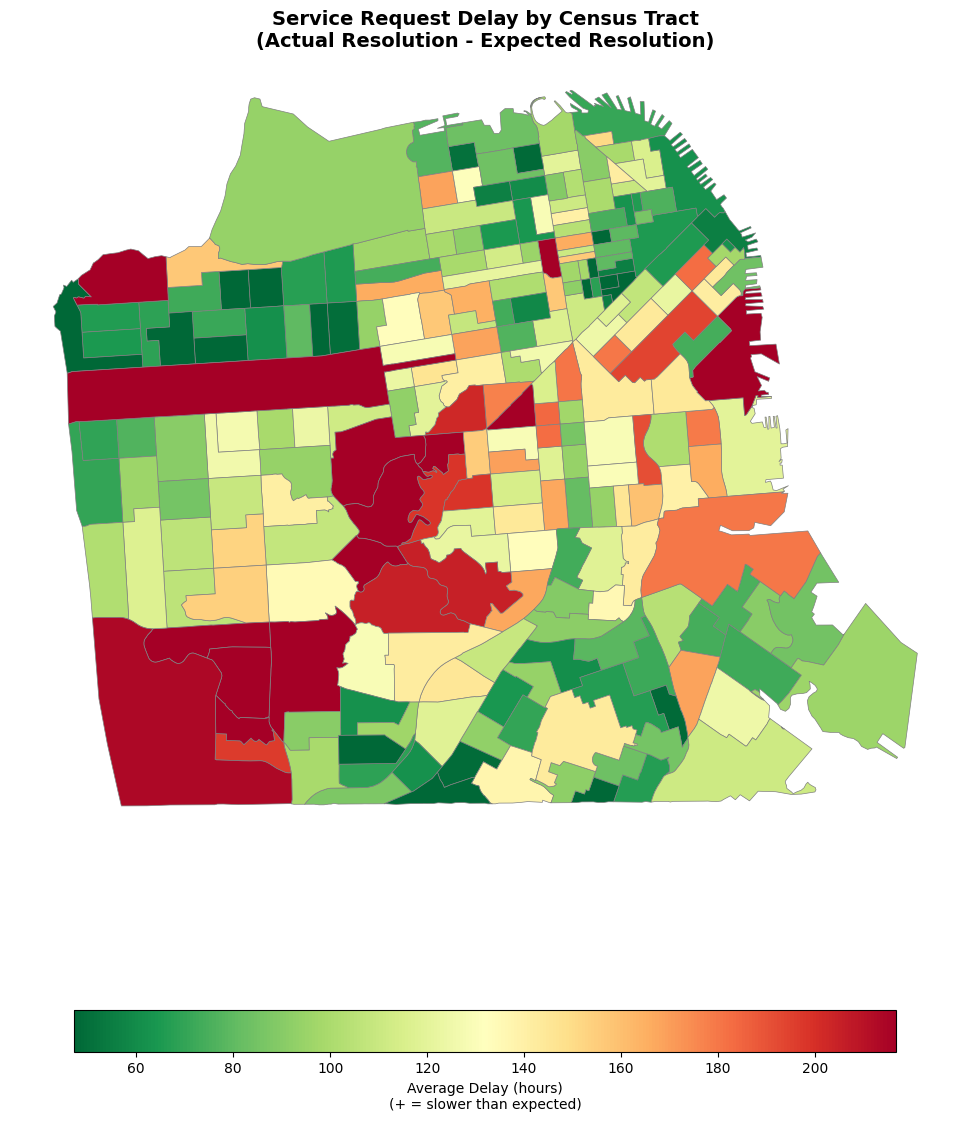

In [6]:
# Merge delay data with tract geometries
tract_delay_map = sf_tracts_gdf.merge(tract_delay, on="GEOID", how="left")

# Create choropleth map of delay
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Use red-to-green colormap: red = positive delay (slower), green = negative delay (faster)
# Set vmin/vmax based on actual data to capture all meaningful variation (5th to 95th percentile)
vmin = tract_delay["avg_delay_hours"].quantile(0.05)
vmax = tract_delay["avg_delay_hours"].quantile(0.95)

tract_delay_map.plot(
    column="avg_delay_hours",
    ax=ax,
    cmap="RdYlGn_r",  # Red for positive (slow), Green for negative (fast)
    edgecolor="gray",
    linewidth=0.5,
    legend=True,
    vmin=vmin,
    vmax=vmax,
    legend_kwds={
        "label": "Average Delay (hours)\n(+ = slower than expected)",
        "orientation": "horizontal",
        "shrink": 0.6,
    },
)

ax.set_title(
    "Service Request Delay by Census Tract\n(Actual Resolution - Expected Resolution)",
    fontsize=14,
    fontweight="bold",
)
ax.axis("off")
plt.tight_layout()
plt.savefig("../figures/delay_choropleth_by_tract.png", dpi=300, bbox_inches="tight")
plt.show()

### Step 5: Correlation Analysis - Delay vs. Demographic/Economic Factors

Test whether delays correlate with income, housing costs, and racial composition.


In [7]:
# Prepare correlation dataframe with relevant demographic variables
# List of demographic columns to check (using actual column names)
demographic_cols = [
    "median_household_income",
    "median_home_value",
    "median_rent",
    "poverty_rate",
    "gini_index",
    "pct_renter_occupied",
    "share_white",
    "share_black",
    "share_asian",
    "share_hispanic",
    "bachelors_plus_rate",
    "total_population",
]

# Get available columns
available_cols = [col for col in demographic_cols if col in sf_tracts_gdf.columns]

print(f"Available demographic variables: {available_cols}")

# Build correlation dataframe
corr_df = sf_tracts_gdf[["GEOID"] + available_cols].merge(
    tract_delay[["GEOID", "avg_delay_hours", "median_delay_hours", "request_count"]],
    on="GEOID",
    how="inner",
)

# Filter to tracts with at least 10 requests for reliability
corr_df = corr_df[corr_df["request_count"] >= 10]

print(f"\nCorrelation analysis based on {len(corr_df)} tracts with 10+ requests")

# Compute Pearson correlations
print("\n=== PEARSON CORRELATIONS WITH AVERAGE DELAY ===\n")
correlations = {}
for col in available_cols:
    if corr_df[col].notna().sum() > 5:  # Require at least 5 valid pairs
        r, p_val = pearsonr(
            corr_df[col].dropna(), corr_df.loc[corr_df[col].notna(), "avg_delay_hours"]
        )
        correlations[col] = {"r": r, "p_value": p_val}
        sig = (
            "***"
            if p_val < 0.001
            else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
        )
        print(f"{col:30s}: r = {r:7.3f}, p = {p_val:.4f} {sig}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

Available demographic variables: ['median_household_income', 'median_home_value', 'median_rent', 'poverty_rate', 'gini_index', 'pct_renter_occupied', 'share_white', 'share_black', 'share_asian', 'share_hispanic', 'bachelors_plus_rate', 'total_population']

Correlation analysis based on 240 tracts with 10+ requests

=== PEARSON CORRELATIONS WITH AVERAGE DELAY ===

median_household_income       : r =   0.261, p = 0.0000 ***
median_home_value             : r =   0.146, p = 0.0308 *
median_rent                   : r =   0.278, p = 0.0000 ***
poverty_rate                  : r =  -0.018, p = 0.7870 ns
gini_index                    : r =   0.005, p = 0.9388 ns
pct_renter_occupied           : r =  -0.077, p = 0.2382 ns
share_white                   : r =   0.203, p = 0.0016 **
share_black                   : r =   0.042, p = 0.5200 ns
share_asian                   : r =  -0.185, p = 0.0041 **
share_hispanic                : r =  -0.097, p = 0.1350 ns
bachelors_plus_rate           : r =   0.254

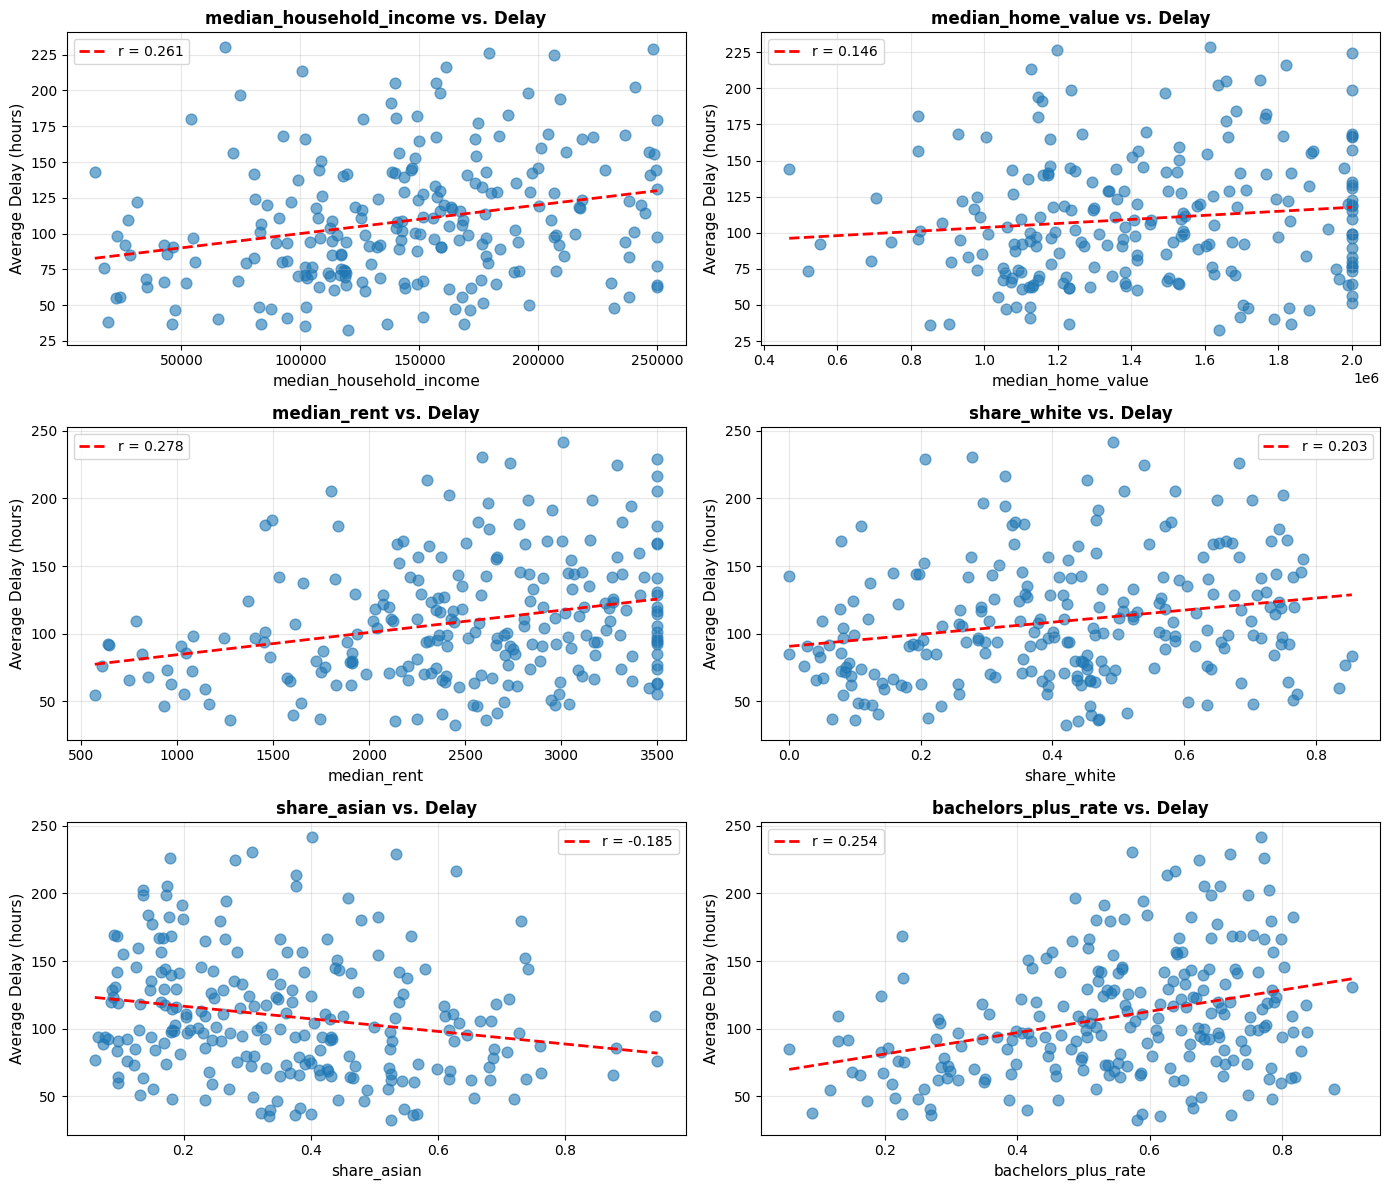


Significant correlations found with: median_household_income, median_home_value, median_rent, share_white, share_asian, bachelors_plus_rate


In [8]:
# Visualize key correlations
sig_cols = [col for col, stats in correlations.items() if stats["p_value"] < 0.05]

if len(sig_cols) > 0:
    n_plots = len(sig_cols)
    n_cols = 2
    n_rows = (n_plots + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(sig_cols):
        ax = axes[idx]
        r = correlations[col]["r"]

        # Scatter plot with regression line
        corr_df_clean = corr_df[[col, "avg_delay_hours"]].dropna()

        # Remove outliers from both axes using IQR method for robust visualization
        Q1_x = corr_df_clean[col].quantile(0.25)
        Q3_x = corr_df_clean[col].quantile(0.75)
        IQR_x = Q3_x - Q1_x
        mask_x = (corr_df_clean[col] >= Q1_x - 1.5 * IQR_x) & (
            corr_df_clean[col] <= Q3_x + 1.5 * IQR_x
        )

        Q1_y = corr_df_clean["avg_delay_hours"].quantile(0.25)
        Q3_y = corr_df_clean["avg_delay_hours"].quantile(0.75)
        IQR_y = Q3_y - Q1_y
        mask_y = (corr_df_clean["avg_delay_hours"] >= Q1_y - 1.5 * IQR_y) & (
            corr_df_clean["avg_delay_hours"] <= Q3_y + 1.5 * IQR_y
        )

        corr_df_filtered = corr_df_clean[mask_x & mask_y]

        ax.scatter(
            corr_df_filtered[col], corr_df_filtered["avg_delay_hours"], alpha=0.6, s=60
        )

        # Add trendline (using filtered data)
        z = np.polyfit(corr_df_filtered[col], corr_df_filtered["avg_delay_hours"], 1)
        p = np.poly1d(z)
        x_line = np.linspace(
            corr_df_filtered[col].min(), corr_df_filtered[col].max(), 100
        )
        ax.plot(x_line, p(x_line), "r--", linewidth=2, label=f"r = {r:.3f}")

        ax.set_xlabel(col, fontsize=11)
        ax.set_ylabel("Average Delay (hours)", fontsize=11)
        ax.set_title(f"{col} vs. Delay", fontsize=12, fontweight="bold")
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(len(sig_cols), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.savefig(
        "../figures/demographic_delay_correlations.png", dpi=300, bbox_inches="tight"
    )
    plt.show()

    print(f"\nSignificant correlations found with: {', '.join(sig_cols)}")

else:
    print("\nNo significant correlations found at p < 0.05")

## Silent Neighborhoods: Where Problems May Exist But Aren't Reported

Question: Where might problems exist but residents aren't reporting them?

We identify neighborhoods with high vulnerability indicators (poverty, renter share) but LOW 311 usage—potentially indicating barriers to complaint filing or underreporting of issues.


In [9]:
# Compute requests per capita
silent_df = sf_tracts_gdf[
    ["GEOID", "total_population", "poverty_rate", "pct_renter_occupied"]
].copy()

# Merge with request counts
silent_df = silent_df.merge(
    tract_delay[["GEOID", "request_count"]], on="GEOID", how="left"
)

# Fill NaN request counts with 0
silent_df["request_count"] = silent_df["request_count"].fillna(0)

# Compute requests per 1000 residents
silent_df["requests_per_1000"] = (
    silent_df["request_count"] / silent_df["total_population"]
) * 1000

print("Requests per 1000 residents - statistics:")
print(silent_df["requests_per_1000"].describe())

# Normalize and combine poverty rate and renter share
silent_df["vulnerability_score"] = (
    (silent_df["poverty_rate"] - silent_df["poverty_rate"].min())
    / (silent_df["poverty_rate"].max() - silent_df["poverty_rate"].min())
    + (silent_df["pct_renter_occupied"] - silent_df["pct_renter_occupied"].min())
    / (silent_df["pct_renter_occupied"].max() - silent_df["pct_renter_occupied"].min())
) / 2

print("\nVulnerability score - statistics:")
print(silent_df["vulnerability_score"].describe())

# High vulnerability + low request rate (below 25th percentile)
req_25th = silent_df["requests_per_1000"].quantile(0.25)
vuln_75th = silent_df["vulnerability_score"].quantile(0.75)

silent_df["is_silent"] = (silent_df["vulnerability_score"] >= vuln_75th) & (
    silent_df["requests_per_1000"] <= req_25th
)

print(f"\n=== SILENT NEIGHBORHOODS ===")
print(
    f"Criteria: Vulnerability ≥ 75th percentile AND Requests per 1000 ≤ 25th percentile"
)
print(f"Vulnerability threshold: {vuln_75th:.3f}")
print(f"Request rate threshold: {req_25th:.2f} per 1000 residents")
print(f"\nTotal silent neighborhoods: {silent_df['is_silent'].sum()}")

silent_neighborhoods = silent_df[silent_df["is_silent"]].sort_values(
    "vulnerability_score", ascending=False
)
print(f"\nTop Silent Neighborhoods (high vulnerability, low reporting):")
display(
    silent_neighborhoods[
        [
            "GEOID",
            "poverty_rate",
            "pct_renter_occupied",
            "vulnerability_score",
            "requests_per_1000",
            "request_count",
            "total_population",
        ]
    ].head(15)
)

Requests per 1000 residents - statistics:
count       240.000000
mean       1551.063275
std        9500.683921
min          76.946198
25%         405.911012
50%         646.588606
75%        1157.607434
max      146795.918367
Name: requests_per_1000, dtype: float64

Vulnerability score - statistics:
count    239.000000
mean       0.375448
std        0.161502
min        0.037383
25%        0.259551
50%        0.364754
75%        0.475863
max        1.000000
Name: vulnerability_score, dtype: float64

=== SILENT NEIGHBORHOODS ===
Criteria: Vulnerability ≥ 75th percentile AND Requests per 1000 ≤ 25th percentile
Vulnerability threshold: 0.476
Request rate threshold: 405.91 per 1000 residents

Total silent neighborhoods: 7

Top Silent Neighborhoods (high vulnerability, low reporting):


,GEOID,poverty_rate,pct_renter_occupied,vulnerability_score,requests_per_1000,request_count,total_population
189,06075033201,0.437421,0.989916,0.779629,160.113154,566,3535.0
128,06075023103,0.407358,0.970356,0.749873,183.289007,827,4512.0
36,06075012502,0.318142,1.000000,0.707194,387.715931,1818,4689.0
191,06075033204,0.304779,1.000000,0.698491,76.946198,256,3327.0
190,06075033203,0.160228,0.914412,0.559821,122.192273,408,3339.0
217,06075060502,0.237565,0.720000,0.509041,92.322643,285,3087.0
215,06075060100,0.007363,1.000000,0.504795,128.676471,490,3808.0


### Visualization: Silent Neighborhoods Map

Map showing which tracts are silent (high vulnerability + low reporting).


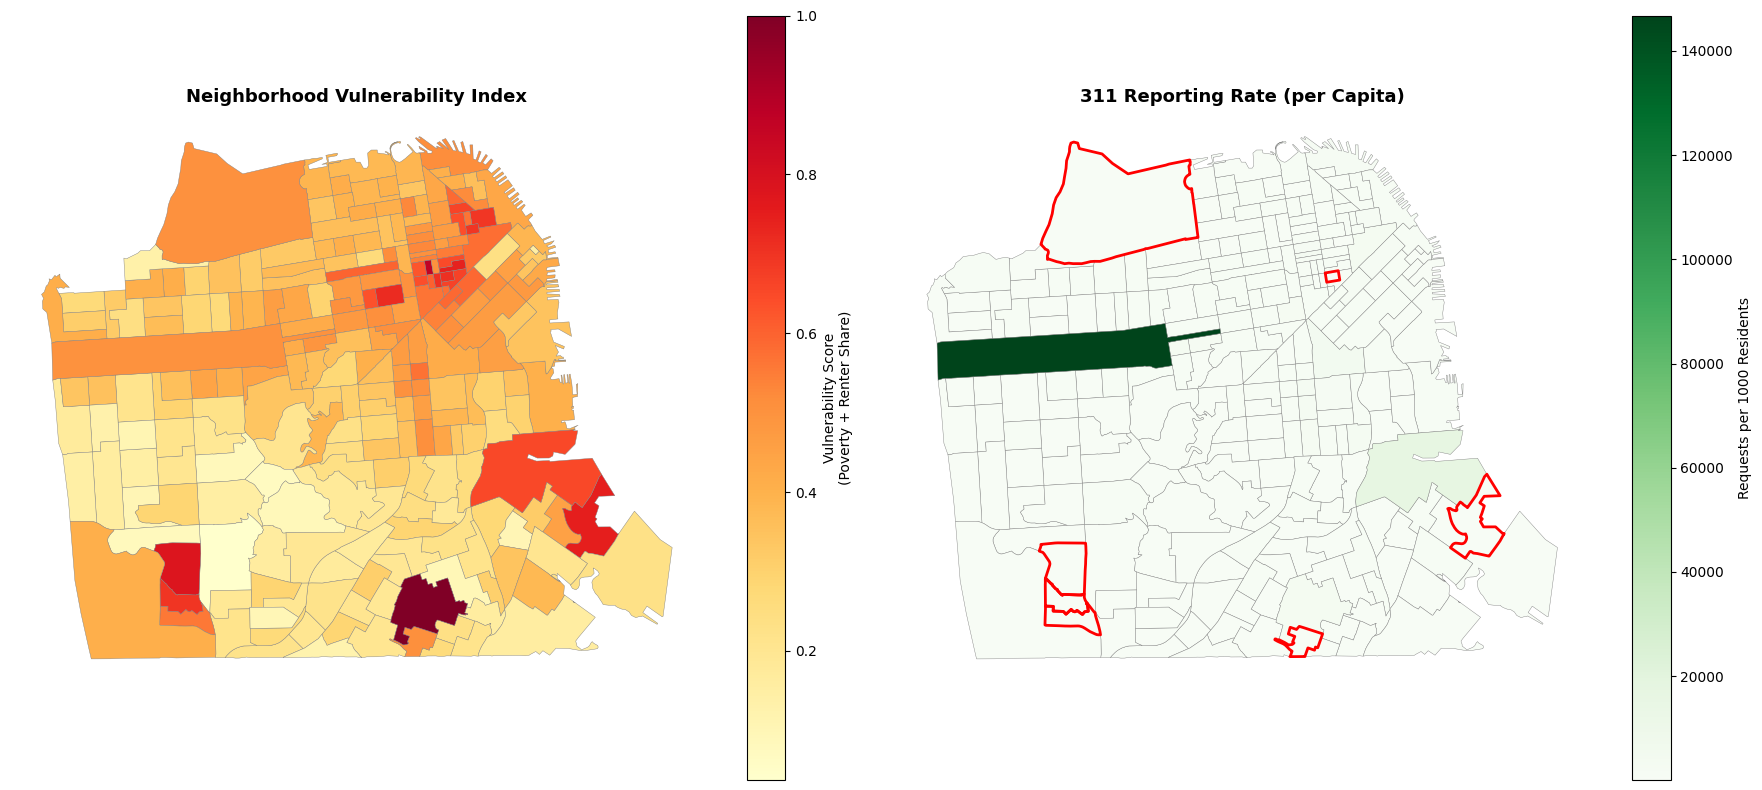

In [10]:
# Merge silent indicators with tract geometries
silent_map = sf_tracts_gdf.merge(
    silent_df[["GEOID", "vulnerability_score", "requests_per_1000", "is_silent"]],
    on="GEOID",
    how="left",
)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Vulnerability Score
silent_map.plot(
    column="vulnerability_score",
    ax=axes[0],
    cmap="YlOrRd",
    edgecolor="gray",
    linewidth=0.3,
    legend=True,
    legend_kwds={
        "label": "Vulnerability Score\n(Poverty + Renter Share)",
        "orientation": "vertical",
    },
)
axes[0].set_title("Neighborhood Vulnerability Index", fontsize=13, fontweight="bold")
axes[0].axis("off")

# Request Rate per Capita
silent_map.plot(
    column="requests_per_1000",
    ax=axes[1],
    cmap="Greens",
    edgecolor="gray",
    linewidth=0.3,
    legend=True,
    legend_kwds={"label": "Requests per 1000 Residents", "orientation": "vertical"},
)

silent_only = silent_map[silent_map["is_silent"] == True]
if len(silent_only) > 0:
    silent_only.plot(
        ax=axes[1],
        facecolor="none",
        edgecolor="red",
        linewidth=2,
        label="Silent Neighborhoods",
    )

axes[1].set_title("311 Reporting Rate (per Capita)", fontsize=13, fontweight="bold")
axes[1].axis("off")

plt.tight_layout()
plt.savefig("../figures/silent_neighborhoods_map.png", dpi=300, bbox_inches="tight")
plt.show()

Removed 13 outliers (out of 240 tracts)
Request rate range after outlier removal: 76.95 to 2257.60


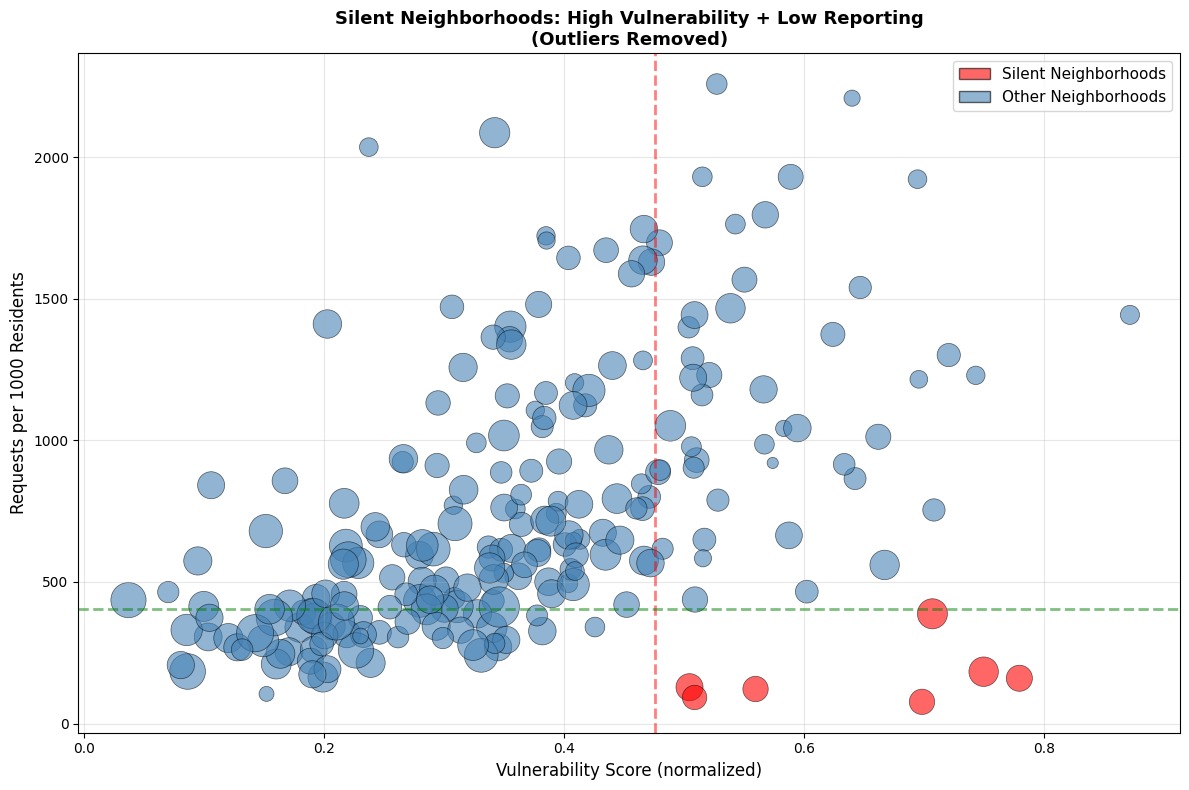

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

Q1 = silent_df["requests_per_1000"].quantile(0.25)
Q3 = silent_df["requests_per_1000"].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (silent_df["requests_per_1000"] >= Q1 - 1.5 * IQR) & (
    silent_df["requests_per_1000"] <= Q3 + 1.5 * IQR
)
silent_df_clean = silent_df[outlier_mask]

print(
    f"Removed {len(silent_df) - len(silent_df_clean)} outliers (out of {len(silent_df)} tracts)"
)
print(
    f"Request rate range after outlier removal: {silent_df_clean['requests_per_1000'].min():.2f} to {silent_df_clean['requests_per_1000'].max():.2f}"
)

colors = silent_df_clean["is_silent"].map({True: "red", False: "steelblue"})
sizes = silent_df_clean["total_population"] / 10  # Scale point size by population

ax.scatter(
    silent_df_clean["vulnerability_score"],
    silent_df_clean["requests_per_1000"],
    c=colors,
    s=sizes,
    alpha=0.6,
    edgecolors="black",
    linewidth=0.5,
)

ax.axvline(
    vuln_75th,
    color="red",
    linestyle="--",
    linewidth=2,
    alpha=0.5,
    label=f"High Vulnerability (75th %ile)",
)
ax.axhline(
    req_25th,
    color="green",
    linestyle="--",
    linewidth=2,
    alpha=0.5,
    label=f"Low Request Rate (25th %ile)",
)

ax.set_xlabel("Vulnerability Score (normalized)", fontsize=12)
ax.set_ylabel("Requests per 1000 Residents", fontsize=12)
ax.set_title(
    "Silent Neighborhoods: High Vulnerability + Low Reporting\n(Outliers Removed)",
    fontsize=13,
    fontweight="bold",
)
ax.grid(True, alpha=0.3)

legend_elements = [
    Patch(facecolor="red", alpha=0.6, edgecolor="black", label="Silent Neighborhoods"),
    Patch(
        facecolor="steelblue", alpha=0.6, edgecolor="black", label="Other Neighborhoods"
    ),
]
ax.legend(handles=legend_elements, fontsize=11, loc="upper right")

plt.tight_layout()
plt.savefig("../figures/silent_neighborhoods_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

### Silent Tracts Demographic Comparison

How do tracts with the lowest 311 reporting rates compare demographically to those with higher reporting?

We compare tracts in the bottom quartile of requests per capita to all others on key ACS indicators.


In [12]:
# Use requests_per_1000 as the reporting metric
requests_per_capita_q25 = silent_df["requests_per_1000"].quantile(0.25)

silent_df["is_silent_quartile"] = (
    silent_df["requests_per_1000"] <= requests_per_capita_q25
)

n_silent = silent_df["is_silent_quartile"].sum()
n_not_silent = (~silent_df["is_silent_quartile"]).sum()

print(f"=== SILENT TRACTS DEFINITION ===")
print(f"Silent tracts (bottom quartile): {n_silent}")
print(f"Non-silent tracts: {n_not_silent}")
print(
    f"Reporting rate threshold: {requests_per_capita_q25:.2f} requests per 1000 residents"
)

=== SILENT TRACTS DEFINITION ===
Silent tracts (bottom quartile): 60
Non-silent tracts: 180
Reporting rate threshold: 405.91 requests per 1000 residents


In [13]:
# Check for median_household_income; if not in silent_df, merge from sf_tracts_gdf
if "median_household_income" not in silent_df.columns:
    silent_df = silent_df.merge(
        sf_tracts_gdf[["GEOID", "median_household_income"]], on="GEOID", how="left"
    )

# Select demographic columns for comparison
comparison_cols = [
    "median_household_income",
    "pct_renter_occupied",
    "poverty_rate",
    "requests_per_1000",
]

# Ensure all columns exist
available_comparison_cols = [col for col in comparison_cols if col in silent_df.columns]

print(f"\nAvailable columns for comparison: {available_comparison_cols}")

# Create comparison groups
silent_tracts = silent_df[silent_df["is_silent_quartile"]]
non_silent_tracts = silent_df[~silent_df["is_silent_quartile"]]

print(
    f"\nSilent tracts n={len(silent_tracts)}, Non-silent tracts n={len(non_silent_tracts)}"
)


Available columns for comparison: ['median_household_income', 'pct_renter_occupied', 'poverty_rate', 'requests_per_1000']

Silent tracts n=60, Non-silent tracts n=180


In [14]:
comparison_results = []

for col in available_comparison_cols:
    silent_data = silent_tracts[col].dropna()
    non_silent_data = non_silent_tracts[col].dropna()

    # Compute means
    mean_silent = silent_data.mean()
    mean_non_silent = non_silent_data.mean()

    # Compute difference
    difference = mean_silent - mean_non_silent
    pct_difference = (
        (difference / mean_non_silent * 100) if mean_non_silent != 0 else np.nan
    )

    # Run t-test if column is income or renter share (as requested)
    if col in ["median_household_income", "pct_renter_occupied"]:
        t_stat, p_value = ttest_ind(silent_data, non_silent_data)
    else:
        t_stat, p_value = np.nan, np.nan

    comparison_results.append(
        {
            "Characteristic": col,
            "Silent Tracts (Mean)": mean_silent,
            "Non-Silent Tracts (Mean)": mean_non_silent,
            "Difference": difference,
            "% Difference": pct_difference,
            "t-statistic": t_stat,
            "p-value": p_value,
            "n_silent": len(silent_data),
            "n_non_silent": len(non_silent_data),
        }
    )

# Create summary table
summary_table = pd.DataFrame(comparison_results)

print("\n=== DEMOGRAPHIC COMPARISON: SILENT VS. NON-SILENT TRACTS ===\n")
display(summary_table)


=== DEMOGRAPHIC COMPARISON: SILENT VS. NON-SILENT TRACTS ===



,Characteristic,Silent Tracts (Mean),Non-Silent Tracts (Mean),Difference,% Difference,t-statistic,p-value,n_silent,n_non_silent
0,median_household_income,149909.700000,142689.494318,7220.205682,5.060082,0.832329,4.060718e-01,60,176
1,pct_renter_occupied,0.437504,0.676691,-0.239187,-35.346626,-7.559227,8.838034e-13,60,179
2,poverty_rate,0.097138,0.120992,-0.023853,-19.714890,NaN,NaN,60,179
3,requests_per_1000,284.387128,1973.288657,-1688.901529,-85.588164,NaN,NaN,60,180


In [15]:
print("\n=== T-TEST RESULTS FOR KEY DEMOGRAPHIC DIFFERENCES ===\n")

for idx, row in summary_table.iterrows():
    if row["Characteristic"] in ["median_household_income", "pct_renter_occupied"]:
        print(f"{row['Characteristic']}:")

        if row["Characteristic"] == "median_household_income":
            print(f"  Silent tracts mean: ${row['Silent Tracts (Mean)']:,.0f}")
            print(f"  Non-silent tracts mean: ${row['Non-Silent Tracts (Mean)']:,.0f}")
            print(f"  Difference: ${row['Difference']:,.0f}")
        else:  # pct_renter_occupied
            print(f"  Silent tracts mean: {row['Silent Tracts (Mean)']*100:.1f}%")
            print(
                f"  Non-silent tracts mean: {row['Non-Silent Tracts (Mean)']*100:.1f}%"
            )
            print(f"  Difference: {row['Difference']*100:.1f} percentage points")

        print(f"  % Difference: {row['% Difference']:.1f}%")

        # Interpret p-value
        if row["p-value"] < 0.001:
            sig_level = "*** (p < 0.001 - highly significant)"
        elif row["p-value"] < 0.01:
            sig_level = "** (p < 0.01 - very significant)"
        elif row["p-value"] < 0.05:
            sig_level = "* (p < 0.05 - significant)"
        else:
            sig_level = "ns (not significant at p < 0.05)"

        print(
            f"  t-test: t = {row['t-statistic']:.3f}, p = {row['p-value']:.4f} {sig_level}"
        )
        print()


=== T-TEST RESULTS FOR KEY DEMOGRAPHIC DIFFERENCES ===

median_household_income:
  Silent tracts mean: $149,910
  Non-silent tracts mean: $142,689
  Difference: $7,220
  % Difference: 5.1%
  t-test: t = 0.832, p = 0.4061 ns (not significant at p < 0.05)

pct_renter_occupied:
  Silent tracts mean: 43.8%
  Non-silent tracts mean: 67.7%
  Difference: -23.9 percentage points
  % Difference: -35.3%
  t-test: t = -7.559, p = 0.0000 *** (p < 0.001 - highly significant)



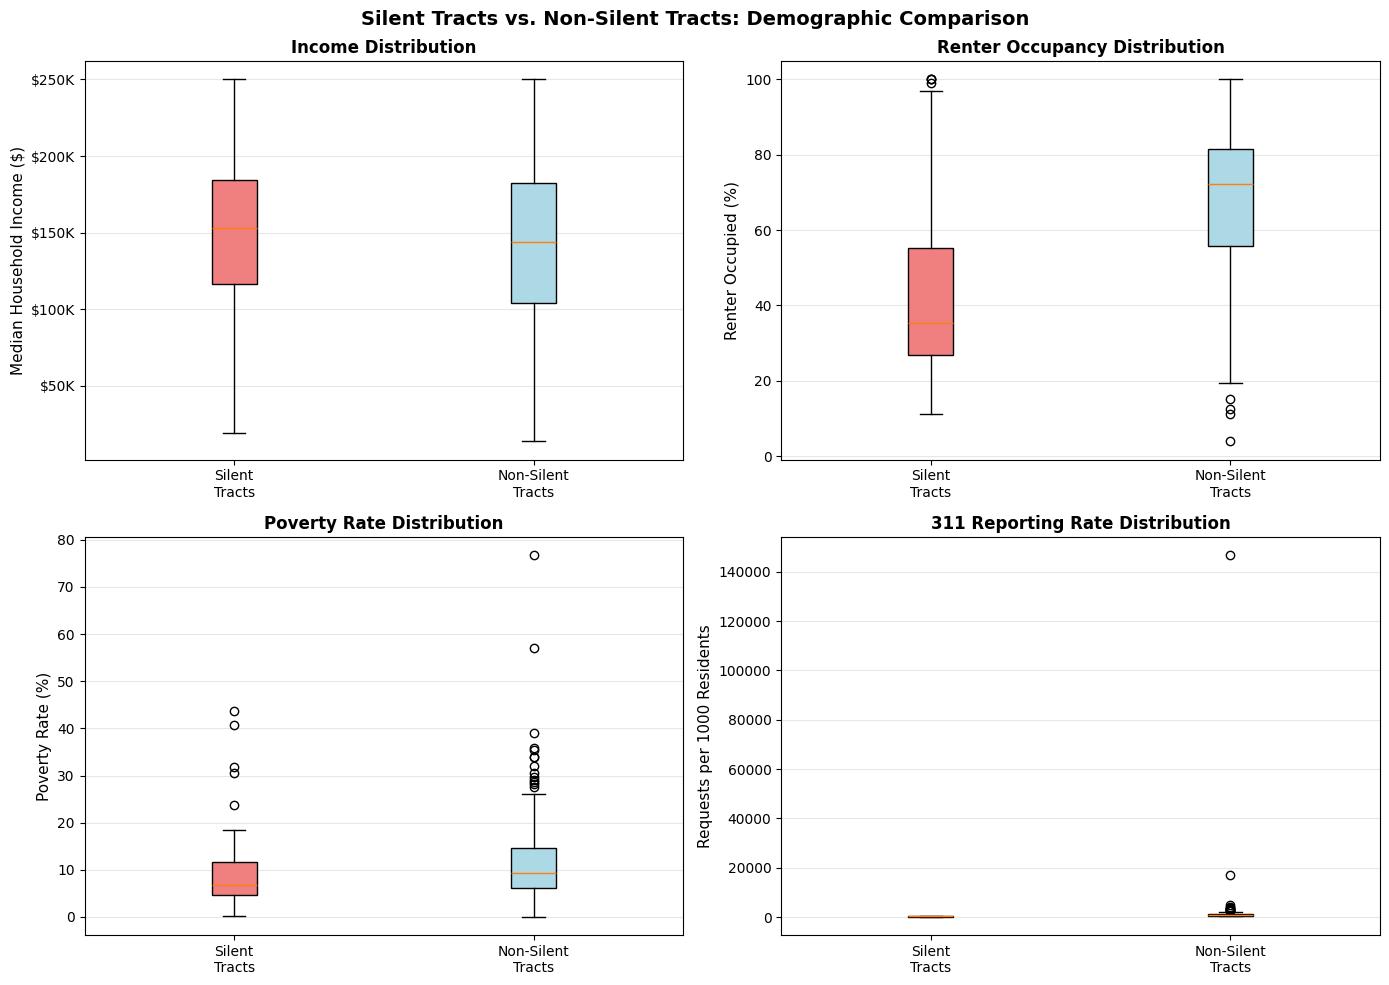

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    "Silent Tracts vs. Non-Silent Tracts: Demographic Comparison",
    fontsize=14,
    fontweight="bold",
)

# Median Household Income
ax = axes[0, 0]
data_income = [
    silent_tracts["median_household_income"].dropna(),
    non_silent_tracts["median_household_income"].dropna(),
]
bp = ax.boxplot(
    data_income, labels=["Silent\nTracts", "Non-Silent\nTracts"], patch_artist=True
)
for patch, color in zip(bp["boxes"], ["lightcoral", "lightblue"]):
    patch.set_facecolor(color)
ax.set_ylabel("Median Household Income ($)", fontsize=11)
ax.set_title("Income Distribution", fontsize=12, fontweight="bold")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x/1000:.0f}K"))
ax.grid(True, alpha=0.3, axis="y")

# Renter Occupancy
ax = axes[0, 1]
data_renter = [
    silent_tracts["pct_renter_occupied"].dropna() * 100,
    non_silent_tracts["pct_renter_occupied"].dropna() * 100,
]
bp = ax.boxplot(
    data_renter, labels=["Silent\nTracts", "Non-Silent\nTracts"], patch_artist=True
)
for patch, color in zip(bp["boxes"], ["lightcoral", "lightblue"]):
    patch.set_facecolor(color)
ax.set_ylabel("Renter Occupied (%)", fontsize=11)
ax.set_title("Renter Occupancy Distribution", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")

# Poverty Rate
ax = axes[1, 0]
data_poverty = [
    silent_tracts["poverty_rate"].dropna() * 100,
    non_silent_tracts["poverty_rate"].dropna() * 100,
]
bp = ax.boxplot(
    data_poverty, labels=["Silent\nTracts", "Non-Silent\nTracts"], patch_artist=True
)
for patch, color in zip(bp["boxes"], ["lightcoral", "lightblue"]):
    patch.set_facecolor(color)
ax.set_ylabel("Poverty Rate (%)", fontsize=11)
ax.set_title("Poverty Rate Distribution", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")

# Reporting Rate
ax = axes[1, 1]
data_requests = [
    silent_tracts["requests_per_1000"].dropna(),
    non_silent_tracts["requests_per_1000"].dropna(),
]
bp = ax.boxplot(
    data_requests, labels=["Silent\nTracts", "Non-Silent\nTracts"], patch_artist=True
)
for patch, color in zip(bp["boxes"], ["lightcoral", "lightblue"]):
    patch.set_facecolor(color)
ax.set_ylabel("Requests per 1000 Residents", fontsize=11)
ax.set_title("311 Reporting Rate Distribution", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(
    "../figures/silent_tracts_demographic_comparison.png", dpi=300, bbox_inches="tight"
)
plt.show()

## Service-Level Equity Analysis: Delay Correlations with Demographics

For which services does government responsiveness vary most by neighborhood income and housing tenure?

We analyze each service category separately to identify which service types show the strongest correlation between delays and demographic factors.


In [17]:
service_analysis_col = service_col

required_cols = [
    service_analysis_col,
    "delay_hours",
    "GEOID",
    "median_household_income",
    "pct_renter_occupied",
]

# First, merge tract demographics with request data
req_with_demographics = req_with_tract[
    [service_analysis_col, "delay_hours", geoid_col_sjoin]
].copy()
req_with_demographics = req_with_demographics.rename(columns={geoid_col_sjoin: "GEOID"})

# Add demographic variables from sf_tracts_gdf
demo_vars = req_with_demographics.merge(
    sf_tracts_gdf[["GEOID", "median_household_income", "pct_renter_occupied"]],
    on="GEOID",
    how="left",
)

# Drop rows missing any required values
demo_vars_clean = demo_vars.dropna(
    subset=[
        service_analysis_col,
        "delay_hours",
        "median_household_income",
        "pct_renter_occupied",
    ]
)

print(f"\nRequests with complete data: {len(demo_vars_clean)}")
print(f"Unique services: {demo_vars_clean[service_analysis_col].nunique()}")


Requests with complete data: 653790
Unique services: 254


In [18]:
# Filter services with at least 100 resolved requests citywide
service_counts = demo_vars_clean[service_analysis_col].value_counts()
services_min_100 = service_counts[service_counts >= 100].index.tolist()

demo_vars_filtered = demo_vars_clean[
    demo_vars_clean[service_analysis_col].isin(services_min_100)
].copy()

print(f"Services with ≥100 requests: {len(services_min_100)}")
print(f"Total requests for these services: {len(demo_vars_filtered)}")
print(f"\nService request counts (top 10):")
print(demo_vars_filtered[service_analysis_col].value_counts().head(10))

Services with ≥100 requests: 69
Total requests for these services: 651408

Service request counts (top 10):
request_type
Garbage / Trash                 126290
Street And Sidewalk Cleaning     95247
Bulky Items                      80701
Graffiti                         68648
Park Maintenance                 59120
Human / Animal Waste             30918
Encampment Reports               28662
Blocking Driveway Cite Only      25669
Request For Service              22045
Blocking Driveway Cite Tow       15285
Name: count, dtype: int64


In [19]:
# Compute Pearson correlation between delay_hours and each demographic variable

service_correlations = []

for service in services_min_100:
    service_data = demo_vars_filtered[
        demo_vars_filtered[service_analysis_col] == service
    ].copy()

    n_requests = len(service_data)

    # Correlation with median_household_income
    income_delay = service_data[["median_household_income", "delay_hours"]].dropna()
    if len(income_delay) >= 5:
        r_income, p_income = pearsonr(
            income_delay["median_household_income"], income_delay["delay_hours"]
        )
    else:
        r_income, p_income = np.nan, np.nan

    # Correlation with percent_renter_occupied
    renter_delay = service_data[["pct_renter_occupied", "delay_hours"]].dropna()
    if len(renter_delay) >= 5:
        r_renter, p_renter = pearsonr(
            renter_delay["pct_renter_occupied"], renter_delay["delay_hours"]
        )
    else:
        r_renter, p_renter = np.nan, np.nan

    service_correlations.append(
        {
            "service": service,
            "n_requests": n_requests,
            "r_income_delay": r_income,
            "p_income_delay": p_income,
            "r_renter_delay": r_renter,
            "p_renter_delay": p_renter,
        }
    )

service_corr_df = pd.DataFrame(service_correlations).sort_values(
    "r_income_delay", ascending=False
)

print("=== SERVICE-LEVEL DELAY CORRELATIONS WITH DEMOGRAPHICS ===\n")
display(service_corr_df)

=== SERVICE-LEVEL DELAY CORRELATIONS WITH DEMOGRAPHICS ===



,service,n_requests,r_income_delay,p_income_delay,r_renter_delay,p_renter_delay
47,Mechanical Equipment,338,0.297299,2.518003e-08,0.021552,6.929853e-01
5,Human / Animal Waste,30918,0.112813,4.125158e-88,-0.071237,4.431141e-36
58,Damaged Side Sewer Vent Cover,151,0.099598,2.237019e-01,-0.107729,1.879613e-01
29,Entertainment,1470,0.098504,1.551396e-04,-0.035873,1.692406e-01
39,Tipped Over,551,0.096470,2.353572e-02,-0.017417,6.833121e-01
...,...,...,...,...,...,...
56,Building - Infestation Rodent Insect,167,-0.088329,2.563286e-01,0.106388,1.711900e-01
42,Construction Private Property,465,-0.093304,4.432908e-02,-0.020194,6.640443e-01
51,Noise Dog Barking,223,-0.108510,1.060781e-01,0.032798,6.261492e-01
57,Abandoned Vehicle - Other,158,-0.151227,5.786374e-02,0.016656,8.354554e-01


In [20]:
print("\n=== INTERPRETATION ===\n")

print("Services with STRONGEST POSITIVE income–delay correlation")
print("(higher income → longer delays):\n")
positive_income = service_corr_df[service_corr_df["r_income_delay"] > 0.2].head(5)
for idx, row in positive_income.iterrows():
    sig = (
        "***"
        if row["p_income_delay"] < 0.001
        else (
            "**"
            if row["p_income_delay"] < 0.01
            else "*" if row["p_income_delay"] < 0.05 else "ns"
        )
    )
    print(
        f"  {row['service']:40s}: r = {row['r_income_delay']:6.3f} ({sig}), n = {row['n_requests']}"
    )

print("\n\nServices with STRONGEST NEGATIVE income–delay correlation")
print("(higher income → shorter delays):\n")
negative_income = service_corr_df[service_corr_df["r_income_delay"] < -0.2].head(5)
for idx, row in negative_income.iterrows():
    sig = (
        "***"
        if row["p_income_delay"] < 0.001
        else (
            "**"
            if row["p_income_delay"] < 0.01
            else "*" if row["p_income_delay"] < 0.05 else "ns"
        )
    )
    print(
        f"  {row['service']:40s}: r = {row['r_income_delay']:6.3f} ({sig}), n = {row['n_requests']}"
    )

print("\n\nServices with STRONGEST renter–delay correlation")
print("(higher renter share → longer delays):\n")
renter_corr = service_corr_df.sort_values("r_renter_delay", ascending=False).head(5)
for idx, row in renter_corr.iterrows():
    sig = (
        "***"
        if row["p_renter_delay"] < 0.001
        else (
            "**"
            if row["p_renter_delay"] < 0.01
            else "*" if row["p_renter_delay"] < 0.05 else "ns"
        )
    )
    print(
        f"  {row['service']:40s}: r = {row['r_renter_delay']:6.3f} ({sig}), n = {row['n_requests']}"
    )

print("\n\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")


=== INTERPRETATION ===

Services with STRONGEST POSITIVE income–delay correlation
(higher income → longer delays):

  Mechanical Equipment                    : r =  0.297 (***), n = 338


Services with STRONGEST NEGATIVE income–delay correlation
(higher income → shorter delays):

  Abandoned Vehicle - Pickuptruck         : r = -0.205 (***), n = 281


Services with STRONGEST renter–delay correlation
(higher renter share → longer delays):

  Abandoned Vehicle - Pickuptruck         : r =  0.149 (*), n = 281
  Building - Infestation Rodent Insect    : r =  0.106 (ns), n = 167
  Abandoned Vehicle - Car4Door            : r =  0.091 (*), n = 550
  Pavement Defect                         : r =  0.077 (***), n = 3955
  Damaged Transit Shelter/Platform        : r =  0.072 (ns), n = 450


Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


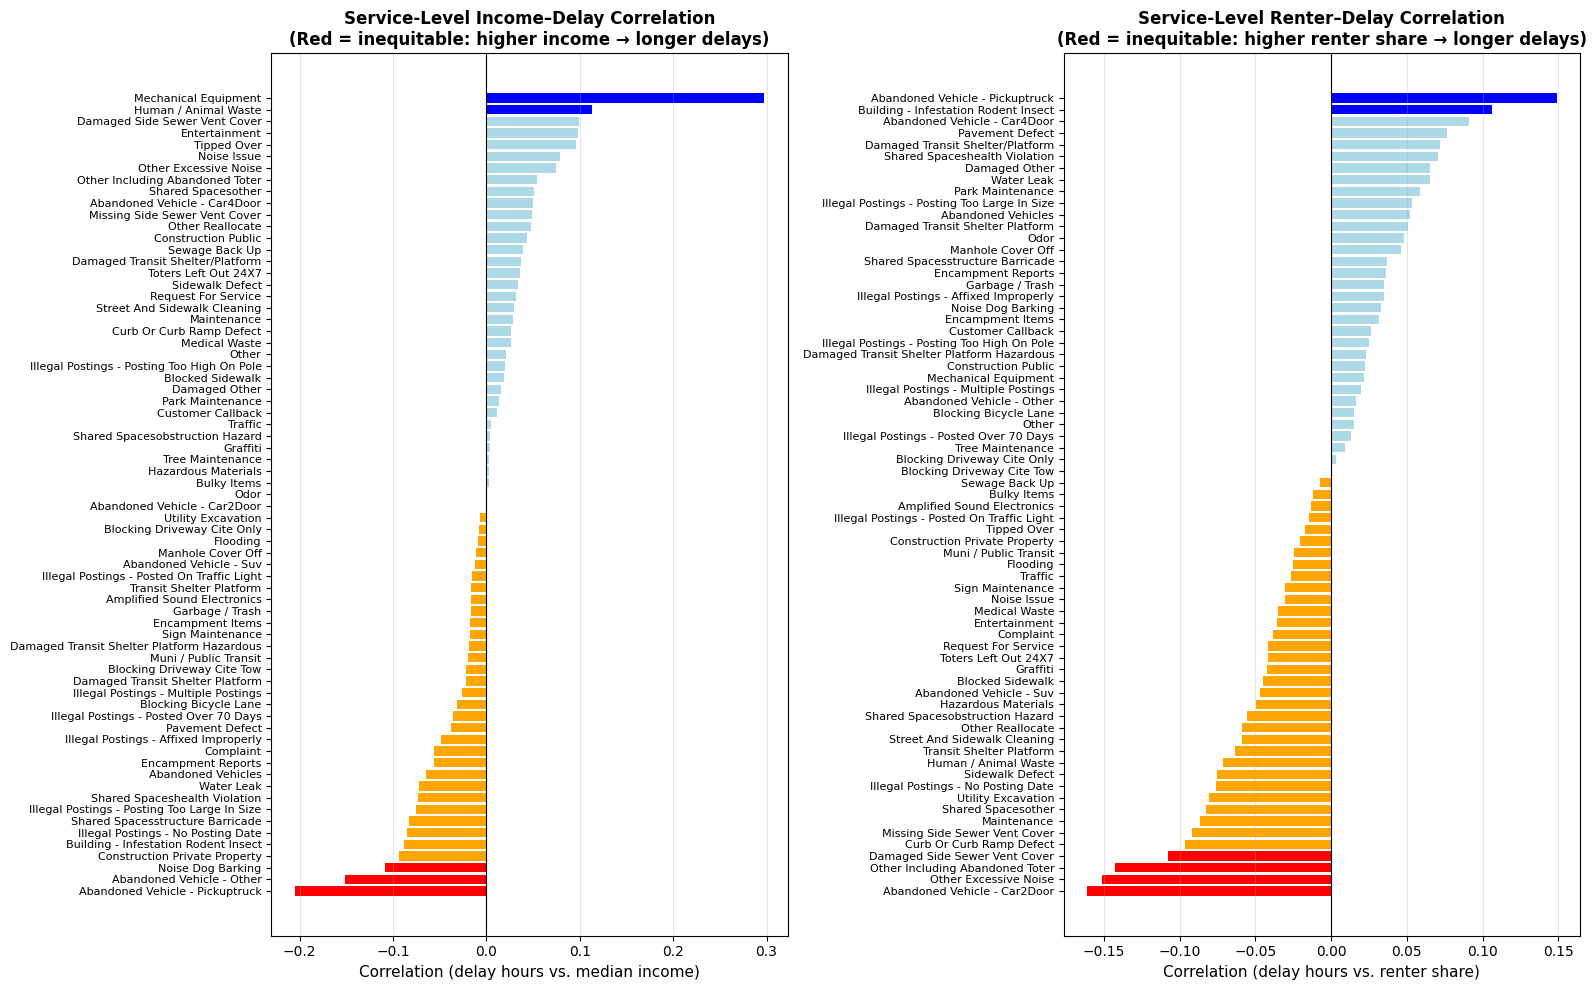

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Income-Delay Correlations
service_corr_sorted = service_corr_df.sort_values("r_income_delay")
colors_income = [
    "red" if x < -0.1 else "orange" if x < 0 else "lightblue" if x < 0.1 else "blue"
    for x in service_corr_sorted["r_income_delay"]
]

axes[0].barh(
    range(len(service_corr_sorted)),
    service_corr_sorted["r_income_delay"],
    color=colors_income,
)
axes[0].set_yticks(range(len(service_corr_sorted)))
axes[0].set_yticklabels(service_corr_sorted["service"], fontsize=8)
axes[0].set_xlabel("Correlation (delay hours vs. median income)", fontsize=11)
axes[0].set_title(
    "Service-Level Income–Delay Correlation\n(Red = inequitable: higher income → longer delays)",
    fontsize=12,
    fontweight="bold",
)
axes[0].axvline(0, color="black", linestyle="-", linewidth=0.8)
axes[0].grid(True, alpha=0.3, axis="x")

# Renter–Delay Correlations
service_corr_renter = service_corr_df.sort_values("r_renter_delay")
colors_renter = [
    "red" if x < -0.1 else "orange" if x < 0 else "lightblue" if x < 0.1 else "blue"
    for x in service_corr_renter["r_renter_delay"]
]

axes[1].barh(
    range(len(service_corr_renter)),
    service_corr_renter["r_renter_delay"],
    color=colors_renter,
)
axes[1].set_yticks(range(len(service_corr_renter)))
axes[1].set_yticklabels(service_corr_renter["service"], fontsize=8)
axes[1].set_xlabel("Correlation (delay hours vs. renter share)", fontsize=11)
axes[1].set_title(
    "Service-Level Renter–Delay Correlation\n(Red = inequitable: higher renter share → longer delays)",
    fontsize=12,
    fontweight="bold",
)
axes[1].axvline(0, color="black", linestyle="-", linewidth=0.8)
axes[1].grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.savefig("../figures/service_level_correlations.png", dpi=300, bbox_inches="tight")
plt.show()

## Counterfactual / Residual Equity Analysis

**Question**: After controlling for service type, request volume, and demographic factors, which neighborhoods still experience systematically longer delays?

We fit a regression model predicting delay_hours using:

- Service category (fixed effects)
- Median household income
- Percent renter-occupied
- Request volume per tract

Then identify tracts with the largest **positive residuals** (actual delays exceed what the model predicts).


In [22]:
residual_df = demo_vars_clean.copy()
residual_df = residual_df.rename(columns={service_analysis_col: "service_base"})

request_volume_by_tract = (
    residual_df.groupby("GEOID").size().reset_index(name="request_volume_tract")
)

residual_df = residual_df.merge(request_volume_by_tract, on="GEOID", how="left")

print("=== STEP 1: REQUEST-LEVEL DATA PREPARATION ===")
print(f"Total requests with complete data: {len(residual_df)}")
print(f"Unique tracts: {residual_df['GEOID'].nunique()}")
print(f"Unique service types: {residual_df['service_base'].nunique()}")
print("\nColumns available:")
print(
    residual_df[
        [
            "delay_hours",
            "service_base",
            "GEOID",
            "median_household_income",
            "pct_renter_occupied",
            "request_volume_tract",
        ]
    ].head()
)

=== STEP 1: REQUEST-LEVEL DATA PREPARATION ===
Total requests with complete data: 653790
Unique tracts: 236
Unique service types: 254

Columns available:
   delay_hours                  service_base        GEOID  \
0   -11.147500                   Bulky Items  06075012002   
1    -6.053889                   Bulky Items  06075025300   
2    -0.033333  Street And Sidewalk Cleaning  06075012503   
3    92.899722            Abandoned Vehicles  06075023102   
4     2.100000           Hazardous Materials  06075025502   

   median_household_income  pct_renter_occupied  request_volume_tract  
0                  71619.0             0.870493                  3588  
1                 189688.0             0.484043                  3943  
2                  47301.0             0.995011                  2519  
3                  46331.0             0.642730                  1433  
4                 168483.0             0.264754                  2958  


In [23]:
# Prepare data: ensure no missing values in predictors
model_data = residual_df[
    [
        "delay_hours",
        "service_base",
        "median_household_income",
        "pct_renter_occupied",
        "request_volume_tract",
        "GEOID",
    ]
].dropna()

# Collapse rare categories to reduce dummy columns (big speedup when service_base has many levels)
min_n = 200  # adjust if needed; higher = fewer categories = faster
vc = model_data["service_base"].value_counts()
rare = vc[vc < min_n].index
if len(rare) > 0:
    model_data.loc[model_data["service_base"].isin(rare), "service_base"] = "Other"

print("=== STEP 2: FIT LINEAR REGRESSION MODEL ===")
print(f"Data for modeling: {len(model_data)} requests")
print(f"\nModel specification:")
print(
    "  delay_hours ~ C(service_base) + median_household_income + pct_renter_occupied + request_volume_tract"
)
print("\nC(service_base) creates categorical fixed effects for each service type")

# Fit OLS regression with service_base as categorical predictor
model = ols(
    "delay_hours ~ C(service_base) + median_household_income + pct_renter_occupied + request_volume_tract",
    data=model_data,
).fit()

print("\n=== MODEL SUMMARY ===")
print(model.summary())

print(f"\nModel R-squared: {model.rsquared:.4f}")
print(f"Model Adjusted R-squared: {model.rsquared_adj:.4f}")
print(f"Number of observations: {model.nobs:.0f}")

=== STEP 2: FIT LINEAR REGRESSION MODEL ===
Data for modeling: 653790 requests

Model specification:
  delay_hours ~ C(service_base) + median_household_income + pct_renter_occupied + request_volume_tract

C(service_base) creates categorical fixed effects for each service type

=== MODEL SUMMARY ===
                            OLS Regression Results                            
Dep. Variable:            delay_hours   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     745.8
Date:                Mon, 15 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:39:03   Log-Likelihood:            -5.0685e+06
No. Observations:              653790   AIC:                         1.014e+07
Df Residuals:                  653734   BIC:                         1.014e+07
Df Model:                          55                               

In [24]:
model_data["predicted_delay"] = model.fittedvalues
model_data["residual"] = model.resid

print("=== STEP 3: COMPUTE RESIDUALS ===")
print(f"Residuals computed for {len(model_data)} requests")
print("\nResidual statistics:")
print(model_data["residual"].describe())

print("\n=== INTERPRETATION ===")
print("Positive residual: Actual delay LONGER than model predicts (inequitable)")
print("Negative residual: Actual delay SHORTER than model predicts (advantaged)")
print("\nExamples:")
display(
    model_data[
        ["GEOID", "service_base", "delay_hours", "predicted_delay", "residual"]
    ].head(10)
)

=== STEP 3: COMPUTE RESIDUALS ===
Residuals computed for 653790 requests

Residual statistics:
count    6.537900e+05
mean     1.210248e-08
std      5.631865e+02
min     -3.623980e+03
25%     -1.427355e+02
50%     -2.543721e+01
75%     -2.988080e+00
max      8.325380e+03
Name: residual, dtype: float64

=== INTERPRETATION ===
Positive residual: Actual delay LONGER than model predicts (inequitable)
Negative residual: Actual delay SHORTER than model predicts (advantaged)

Examples:


,GEOID,service_base,delay_hours,predicted_delay,residual
0,06075012002,Bulky Items,-11.147500,8.591824,-19.739324
1,06075025300,Bulky Items,-6.053889,19.616360,-25.670249
2,06075012503,Street And Sidewalk Cleaning,-0.033333,33.310234,-33.343567
3,06075023102,Abandoned Vehicles,92.899722,23.609633,69.290089
4,06075025502,Hazardous Materials,2.100000,63.453270,-61.353270
5,06075031000,Bulky Items,-11.468333,23.607075,-35.075409
6,06075016802,Human / Animal Waste,237.583333,62.318178,175.265155
7,06075026403,Bulky Items,-10.264167,18.341826,-28.605993
8,06075015202,Garbage / Trash,-8.476389,16.510465,-24.986854
9,06075030101,Bulky Items,-11.046389,13.197125,-24.243514


In [25]:
tract_residuals = (
    model_data.groupby("GEOID")
    .agg({"residual": ["mean", "median", "count"]})
    .reset_index()
)

tract_residuals.columns = ["GEOID", "mean_residual", "median_residual", "n_requests"]

print("=== STEP 4: AGGREGATE RESIDUALS TO TRACT LEVEL ===")
print(f"Total tracts: {len(tract_residuals)}")
print("\nTract-level residual statistics:")
print(tract_residuals[["mean_residual", "median_residual", "n_requests"]].describe())

tract_residuals = tract_residuals.merge(
    sf_tracts_gdf[
        ["GEOID", "median_household_income", "pct_renter_occupied", "poverty_rate"]
    ],
    on="GEOID",
    how="left",
)

=== STEP 4: AGGREGATE RESIDUALS TO TRACT LEVEL ===
Total tracts: 236

Tract-level residual statistics:
       mean_residual  median_residual    n_requests
count     236.000000       236.000000    236.000000
mean       -0.213513       -33.378128   2770.296610
std        34.488401        22.477154   2011.331691
min      -105.350077      -152.149429    122.000000
25%       -21.993573       -37.797145   1426.000000
50%        -3.129740       -27.257809   2147.500000
75%        18.104755       -20.837920   3516.000000
max       133.745714        -1.716580  11450.000000


In [26]:
min_requests = 30
tract_residuals_filtered = tract_residuals[
    tract_residuals["n_requests"] >= min_requests
].copy()

print(f"=== STEP 5: FILTER & IDENTIFY TOP UNDERPERFORMING TRACTS ===")
print(
    f"Tracts with at least {min_requests} requests: {len(tract_residuals_filtered)} / {len(tract_residuals)}"
)

# Sort by mean residual (highest = worst)
tract_residuals_sorted = tract_residuals_filtered.sort_values(
    "mean_residual", ascending=False
)

# Get top 15
top_15_worst = tract_residuals_sorted.head(15)

print(f"\n=== TOP 15 TRACTS WITH HIGHEST UNEXPLAINED DELAYS ===")
print(
    "(Systematically slower than model predicts, even after controlling for service type, income, renter share, and volume)"
)
print()
display(
    top_15_worst[
        [
            "GEOID",
            "mean_residual",
            "median_residual",
            "n_requests",
            "median_household_income",
            "pct_renter_occupied",
            "poverty_rate",
        ]
    ]
)

print("\n=== KEY INSIGHTS ===")
print(
    f"Mean residual range for top 15: {top_15_worst['mean_residual'].min():.2f} to {top_15_worst['mean_residual'].max():.2f} hours"
)
print(
    f"Average income of top 15: ${top_15_worst['median_household_income'].mean():,.0f}"
)
print(
    f"Average renter share of top 15: {top_15_worst['pct_renter_occupied'].mean()*100:.1f}%"
)
print(f"Average poverty rate of top 15: {top_15_worst['poverty_rate'].mean()*100:.1f}%")

=== STEP 5: FILTER & IDENTIFY TOP UNDERPERFORMING TRACTS ===
Tracts with at least 30 requests: 236 / 236

=== TOP 15 TRACTS WITH HIGHEST UNEXPLAINED DELAYS ===
(Systematically slower than model predicts, even after controlling for service type, income, renter share, and volume)



,GEOID,mean_residual,median_residual,n_requests,median_household_income,pct_renter_occupied,poverty_rate
164,06075030600,133.745714,-34.649119,1094,238750.0,0.151717,0.018251
188,06075033204,95.093793,-137.448087,256,71750.0,1.000000,0.304779
163,06075030500,94.183602,-41.294549,726,182375.0,0.290675,0.110913
213,06075060400,88.261647,-22.879318,979,100583.0,0.723197,0.081958
215,06075060701,82.850486,-100.181540,3464,248177.0,0.658092,0.037163
55,06075015100,81.481190,-43.361923,3064,170568.0,0.640981,0.108464
93,06075020300,79.270162,-26.090704,4575,179313.0,0.633623,0.069988
117,06075022802,76.952771,-20.380058,1807,137969.0,0.561917,0.141966
232,06075980300,75.389088,-14.396151,7193,104333.0,1.000000,0.000000
235,06075980900,71.828157,-14.667154,5503,53800.0,0.866667,0.338509



=== KEY INSIGHTS ===
Mean residual range for top 15: 56.99 to 133.75 hours
Average income of top 15: $134,287
Average renter share of top 15: 67.8%
Average poverty rate of top 15: 15.0%


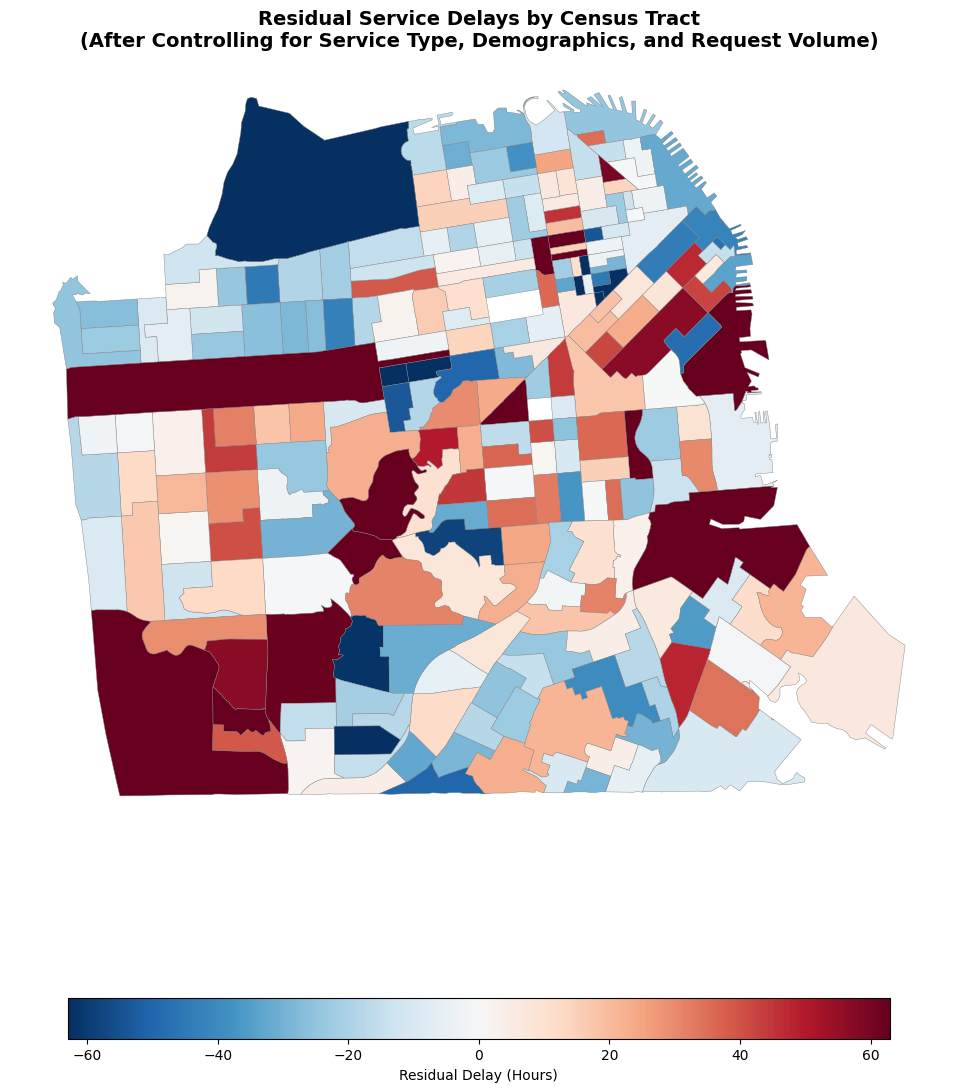


=== MAP INTERPRETATION ===
Color scale clipped at 5th percentile (-50.88 hrs) and 95th percentile (62.94 hrs)
Symmetric range: -62.94 to 62.94 hours (centered at 0)


In [27]:
residual_map = sf_tracts_gdf.merge(tract_residuals_filtered, on="GEOID", how="left")

fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Clip extreme values at 5th and 95th percentiles for better visualization
vmin_res = tract_residuals_filtered["mean_residual"].quantile(0.05)
vmax_res = tract_residuals_filtered["mean_residual"].quantile(0.95)

# Ensure color scale is centered at 0 by making vmin and vmax symmetric
max_abs = max(abs(vmin_res), abs(vmax_res))
vmin_centered = -max_abs
vmax_centered = max_abs

# Create choropleth with diverging colormap centered at 0
residual_map.plot(
    column="mean_residual",
    ax=ax,
    cmap="RdBu_r",
    edgecolor="gray",
    linewidth=0.3,
    legend=True,
    vmin=vmin_centered,
    vmax=vmax_centered,
    legend_kwds={
        "label": "Residual Delay (Hours)",
        "orientation": "horizontal",
        "shrink": 0.6,
    },
)

ax.set_title(
    "Residual Service Delays by Census Tract\n(After Controlling for Service Type, Demographics, and Request Volume)",
    fontsize=14,
    fontweight="bold",
)
ax.axis("off")
plt.tight_layout()
plt.savefig("../figures/residual_delays_choropleth.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n=== MAP INTERPRETATION ===")
print(
    f"Color scale clipped at 5th percentile ({vmin_res:.2f} hrs) and 95th percentile ({vmax_res:.2f} hrs)"
)
print(
    f"Symmetric range: {vmin_centered:.2f} to {vmax_centered:.2f} hours (centered at 0)"
)

### Robustness Check: Median Residuals with Spearman Correlations

To ensure our findings are robust to outliers and non-linear relationships, we repeat the analysis using:

- **Median residuals** instead of mean (more resistant to extreme values)
- **Spearman rank correlations** instead of Pearson (captures monotonic relationships without assuming linearity)

We then compare which tracts appear as underperforming under both approaches.


In [28]:
tract_residuals_sorted_median = tract_residuals_filtered.sort_values(
    "median_residual", ascending=False
)

# Get top 15 by median residual
top_15_worst_median = tract_residuals_sorted_median.head(15)

print("=== TOP 15 TRACTS BY MEDIAN RESIDUAL (Robust to Outliers) ===")

display(
    top_15_worst_median[
        [
            "GEOID",
            "median_residual",
            "mean_residual",
            "n_requests",
            "median_household_income",
            "pct_renter_occupied",
            "poverty_rate",
        ]
    ]
)

print("\n=== COMPARISON: MEAN vs MEDIAN RESIDUAL ===")
print(
    f"Median residual range for top 15: {top_15_worst_median['median_residual'].min():.2f} to {top_15_worst_median['median_residual'].max():.2f} hours"
)
print(
    f"Mean residual range for top 15: {top_15_worst_median['mean_residual'].min():.2f} to {top_15_worst_median['mean_residual'].max():.2f} hours"
)
print(
    f"\nAverage income of top 15 (median method): ${top_15_worst_median['median_household_income'].mean():,.0f}"
)
print(
    f"Average renter share of top 15 (median method): {top_15_worst_median['pct_renter_occupied'].mean()*100:.1f}%"
)
print(
    f"Average poverty rate of top 15 (median method): {top_15_worst_median['poverty_rate'].mean()*100:.1f}%"
)

=== TOP 15 TRACTS BY MEDIAN RESIDUAL (Robust to Outliers) ===


,GEOID,median_residual,mean_residual,n_requests,median_household_income,pct_renter_occupied,poverty_rate
39,06075012601,-1.716580,-30.746897,1330,176750.0,0.796282,0.029829
41,06075012700,-5.883919,-16.865051,1990,250001.0,0.704436,0.063176
20,06075011700,-7.073594,-6.411428,7937,51964.0,0.884788,0.212598
21,06075011800,-7.657883,-0.634935,1987,43833.0,0.994413,0.305199
19,06075011300,-10.194785,-23.007217,2178,35507.0,0.902476,0.297058
0,06075010101,-11.370230,-24.717102,3868,101974.0,0.906766,0.098303
10,06075010702,-11.430090,59.503614,1438,80472.0,0.814540,0.276087
219,06075061101,-11.700237,-3.319751,3486,17569.0,0.925134,0.358875
44,06075012901,-13.117617,-38.324582,1825,231841.0,0.777166,0.026051
199,06075042700,-13.221037,2.123250,2633,119276.0,0.735929,0.069619



=== COMPARISON: MEAN vs MEDIAN RESIDUAL ===
Median residual range for top 15: -14.32 to -1.72 hours
Mean residual range for top 15: -38.32 to 59.50 hours

Average income of top 15 (median method): $112,468
Average renter share of top 15 (median method): 84.4%
Average poverty rate of top 15 (median method): 16.0%


In [29]:
top_15_mean_geoids = set(top_15_worst["GEOID"])
top_15_median_geoids = set(top_15_worst_median["GEOID"])

# Find overlap
overlap_geoids = top_15_mean_geoids.intersection(top_15_median_geoids)
mean_only = top_15_mean_geoids - top_15_median_geoids
median_only = top_15_median_geoids - top_15_mean_geoids

print("=== TRACT OVERLAP ANALYSIS ===\n")
print(f"Tracts in BOTH top 15 lists: {len(overlap_geoids)}")
print(f"Tracts only in mean top 15: {len(mean_only)}")
print(f"Tracts only in median top 15: {len(median_only)}")
print(f"\nOverlap rate: {len(overlap_geoids)/15*100:.1f}%")

if len(overlap_geoids) > 0:
    print(f"\n=== CONSISTENT UNDERPERFORMERS (in both lists) ===")
    overlap_df = tract_residuals_filtered[
        tract_residuals_filtered["GEOID"].isin(overlap_geoids)
    ].sort_values("mean_residual", ascending=False)
    display(
        overlap_df[
            [
                "GEOID",
                "mean_residual",
                "median_residual",
                "n_requests",
                "median_household_income",
                "pct_renter_occupied",
            ]
        ]
    )

if len(mean_only) > 0:
    print(f"\n=== TRACTS ONLY IN MEAN TOP 15 (potentially outlier-driven) ===")
    mean_only_df = tract_residuals_filtered[
        tract_residuals_filtered["GEOID"].isin(mean_only)
    ].sort_values("mean_residual", ascending=False)
    display(
        mean_only_df[
            [
                "GEOID",
                "mean_residual",
                "median_residual",
                "n_requests",
            ]
        ]
    )

if len(median_only) > 0:
    print(f"\n=== TRACTS ONLY IN MEDIAN TOP 15 (more consistent delays) ===")
    median_only_df = tract_residuals_filtered[
        tract_residuals_filtered["GEOID"].isin(median_only)
    ].sort_values("median_residual", ascending=False)
    display(
        median_only_df[
            [
                "GEOID",
                "mean_residual",
                "median_residual",
                "n_requests",
            ]
        ]
    )

=== TRACT OVERLAP ANALYSIS ===

Tracts in BOTH top 15 lists: 1
Tracts only in mean top 15: 14
Tracts only in median top 15: 14

Overlap rate: 6.7%

=== CONSISTENT UNDERPERFORMERS (in both lists) ===


,GEOID,mean_residual,median_residual,n_requests,median_household_income,pct_renter_occupied
10,06075010702,59.503614,-11.43009,1438,80472.0,0.81454



=== TRACTS ONLY IN MEAN TOP 15 (potentially outlier-driven) ===


,GEOID,mean_residual,median_residual,n_requests
164,06075030600,133.745714,-34.649119,1094
188,06075033204,95.093793,-137.448087,256
163,06075030500,94.183602,-41.294549,726
213,06075060400,88.261647,-22.879318,979
215,06075060701,82.850486,-100.181540,3464
55,06075015100,81.481190,-43.361923,3064
93,06075020300,79.270162,-26.090704,4575
117,06075022802,76.952771,-20.380058,1807
232,06075980300,75.389088,-14.396151,7193
235,06075980900,71.828157,-14.667154,5503



=== TRACTS ONLY IN MEDIAN TOP 15 (more consistent delays) ===


,GEOID,mean_residual,median_residual,n_requests
39,06075012601,-30.746897,-1.716580,1330
41,06075012700,-16.865051,-5.883919,1990
20,06075011700,-6.411428,-7.073594,7937
21,06075011800,-0.634935,-7.657883,1987
19,06075011300,-23.007217,-10.194785,2178
0,06075010101,-24.717102,-11.370230,3868
219,06075061101,-3.319751,-11.700237,3486
44,06075012901,-38.324582,-13.117617,1825
199,06075042700,2.123250,-13.221037,2633
70,06075016300,-20.333901,-13.592775,4632


In [30]:
print("=== SPEARMAN RANK CORRELATIONS: MEDIAN RESIDUAL vs. DEMOGRAPHICS ===")
print("(Non-parametric test for monotonic relationships)\n")

# Variables to test
demo_vars_to_test = [
    "median_household_income",
    "pct_renter_occupied",
    "poverty_rate",
    "n_requests",
]

spearman_results = []

for var in demo_vars_to_test:
    clean_data = tract_residuals_filtered[[var, "median_residual"]].dropna()

    if len(clean_data) >= 5:
        rho, p_value = spearmanr(clean_data[var], clean_data["median_residual"])

        # Interpret significance
        if p_value < 0.001:
            sig = "***"
        elif p_value < 0.01:
            sig = "**"
        elif p_value < 0.05:
            sig = "*"
        else:
            sig = "ns"

        spearman_results.append(
            {
                "Variable": var,
                "Spearman_rho": rho,
                "p_value": p_value,
                "significance": sig,
                "n_tracts": len(clean_data),
            }
        )

        print(
            f"{var:30s}: ρ = {rho:7.3f}, p = {p_value:.4f} {sig} (n={len(clean_data)})"
        )

spearman_df = pd.DataFrame(spearman_results)

print("\n\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("\n=== INTERPRETATION ===")
print(
    "Positive ρ: Higher values of demographic variable → higher median residuals (slower)"
)
print(
    "Negative ρ: Higher values of demographic variable → lower median residuals (faster)"
)
print("\nSpearman correlation captures ANY monotonic relationship (not just linear)")

=== SPEARMAN RANK CORRELATIONS: MEDIAN RESIDUAL vs. DEMOGRAPHICS ===
(Non-parametric test for monotonic relationships)

median_household_income       : ρ =  -0.133, p = 0.0407 * (n=236)
pct_renter_occupied           : ρ =   0.243, p = 0.0002 *** (n=236)
poverty_rate                  : ρ =  -0.025, p = 0.7015 ns (n=236)
n_requests                    : ρ =   0.147, p = 0.0237 * (n=236)


Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant

=== INTERPRETATION ===
Positive ρ: Higher values of demographic variable → higher median residuals (slower)
Negative ρ: Higher values of demographic variable → lower median residuals (faster)

Spearman correlation captures ANY monotonic relationship (not just linear)


In [ ]:
# Step 4: Summary comparison table - Mean/Pearson vs Median/Spearman

print("=== COMPREHENSIVE COMPARISON: MEAN/PEARSON vs MEDIAN/SPEARMAN ===\n")

# Create comparison summary
comparison_summary = {
    "Metric": [
        "Aggregation Method",
        "Correlation Type",
        "Resistance to Outliers",
        "Assumes Linearity",
        "Top 15 Tracts Identified",
        "Overlap with Other Method",
        "Avg Income of Top 15",
        "Avg Renter % of Top 15",
        "Avg Poverty % of Top 15",
    ],
    "Mean + Pearson\n(Original)": [
        "Mean residual",
        "Pearson (linear)",
        "Low (sensitive)",
        "Yes",
        f"{len(top_15_mean_geoids)} tracts",
        f"{len(overlap_geoids)} ({len(overlap_geoids)/15*100:.0f}%)",
        f"${top_15_worst['median_household_income'].mean():,.0f}",
        f"{top_15_worst['pct_renter_occupied'].mean()*100:.1f}%",
        f"{top_15_worst['poverty_rate'].mean()*100:.1f}%",
    ],
    "Median + Spearman\n(Robust)": [
        "Median residual",
        "Spearman (rank)",
        "High (robust)",
        "No (monotonic only)",
        f"{len(top_15_median_geoids)} tracts",
        f"{len(overlap_geoids)} ({len(overlap_geoids)/15*100:.0f}%)",
        f"${top_15_worst_median['median_household_income'].mean():,.0f}",
        f"{top_15_worst_median['pct_renter_occupied'].mean()*100:.1f}%",
        f"{top_15_worst_median['poverty_rate'].mean()*100:.1f}%",
    ],
}

comparison_df = pd.DataFrame(comparison_summary)
display(comparison_df)

print("\n=== KEY FINDINGS ===\n")

if len(overlap_geoids) >= 10:
    print(
        f"✓ STRONG AGREEMENT ({len(overlap_geoids)}/15 tracts overlap): Results are ROBUST"
    )
    print("  → These tracts consistently show unexplained delays regardless of method")
    print("  → High confidence in policy intervention targeting")
elif len(overlap_geoids) >= 5:
    print(
        f"◐ MODERATE AGREEMENT ({len(overlap_geoids)}/15 tracts overlap): Some sensitivity"
    )
    print("  → Core set of underperforming tracts identified")
    print("  → Additional tracts may be influenced by outliers or non-linearity")
else:
    print(
        f"✗ LOW AGREEMENT ({len(overlap_geoids)}/15 tracts overlap): Results are SENSITIVE"
    )
    print("  → Findings vary significantly by method")
    print("  → Recommend using median/Spearman for more robust identification")

print(
    f"\nDemographic comparison: {'Similar' if abs(top_15_worst['median_household_income'].mean() - top_15_worst_median['median_household_income'].mean()) < 10000 else 'Different'} income profiles"
)
print(
    f"Renter share comparison: {'Similar' if abs(top_15_worst['pct_renter_occupied'].mean() - top_15_worst_median['pct_renter_occupied'].mean()) < 0.1 else 'Different'} housing tenure"
)

=== COMPREHENSIVE COMPARISON: MEAN/PEARSON vs MEDIAN/SPEARMAN ===



,Metric,Mean + Pearson\n(Original),Median + Spearman\n(Robust)
0,Aggregation Method,Mean residual,Median residual
1,Correlation Type,Pearson (linear),Spearman (rank)
2,Resistance to Outliers,Low (sensitive),High (robust)
3,Assumes Linearity,Yes,No (monotonic only)
4,Top 15 Tracts Identified,15 tracts,15 tracts
5,Overlap with Other Method,1 (7%),1 (7%)
6,Avg Income of Top 15,"$134,287","$112,468"
7,Avg Renter % of Top 15,67.8%,84.4%
8,Avg Poverty % of Top 15,15.0%,16.0%



=== KEY FINDINGS ===

✗ LOW AGREEMENT (1/15 tracts overlap): Results are SENSITIVE
  → Findings vary significantly by method
  → Recommend using median/Spearman for more robust identification

Demographic comparison: Different income profiles
Renter share comparison: Different housing tenure
